# Tension Metrics
The metrics follow [arXiv:2012.09554v2](https://arxiv.org/pdf/2012.09554.pdf). This is a notebook to compute other tension metrics. All metrics follow
$$ n_{\sigma} = \sqrt{2}\text{Erf}^{-1}(\text{PTE}) $$
where PTE is the 'probability to exceed,' which changes for each metric. In this notebook I will use the DES vs Planck test chains from Raveri's tensiometer.

### Parameter DIfference
I will start with parameter based methods. I will use normalizing flows to do the posterior estimation. First, I will start with the usual $P_{\text{shift}}$.
$$\text{PTE} = \int\limits_{\mathcal{P}(\Delta\theta)>\mathcal{P(0)}}\mathcal{P}(\Delta\theta) d\Delta\theta $$

In [1]:
import sys
import os
import numpy as np
import getdist
import pybobyqa
from iminuit import Minuit
from scipy.optimize import minimize

sys.path.append(os.path.join(os.path.dirname("__file__"), '../'))
from metrics import diff
from metrics import flow
from metrics import tension
from metrics.parameter_metrics import *
from metrics import utilities
from emulators import lsst
from emulators import cosmopower

In [2]:
# planck path
planck_path = '/home/grads/data/evan/cosmopower_emcee/notebooks/planck_emulated'
#planck_path = '/home/grads/data/KunHao/GeoGrowth/gg_split_tension/chains/EXAMPLE_MCMC72'
# LSST path
lsst_path = '/home/grads/data/evan/mc_data/fiducial'
#lsst_path = '/home/grads/data/KunHao/GeoGrowth/gg_split_tension/chains/EXAMPLE_MCMC74'

In [3]:
# instantiate diff
# i need to change the LSST names because they do not match planck.
chains = diff.chain()
chain1 = chains.getdist_reader(planck_path)
chain2 = chains.getdist_reader(lsst_path)
#chain2.setParamNames(['logA','ns','H0','omegabh2','omegach2'])
chains.chains = [chain1,chain2]
chains.diff()

/home/grads/data/evan/cosmopower_emcee/notebooks/planck_emulated.txt
Removed no burn in
/home/grads/data/evan/mc_data/fiducial.txt
Removed no burn in


In [45]:
#print(chain1.getParamNames().list())
name1 = chain1.getParamNames().list()
name2 = chain2.getParamNames().list()

params = ['omegab','omegam','As','ns','H0','sigma8_split']
idx1 = [name1.index(param) for param in params]
idx2 = [name2.index(param) for param in params]

samples1 = chain1.samples[...,idx1]
samples2 = chain2.samples[...,idx2]

weight1 = chain1.weights
weight2 = chain2.weights

chain1 = getdist.MCSamples(samples=samples1,weights=weight1,names=params,labels=params)
chain2 = getdist.MCSamples(samples=samples2,weights=weight2,names=params,labels=params)

chains.chains = [chain1,chain2]
chains.diff()

Removed no burn in
Removed no burn in

Params in first chain:
['omegab', 'omegam', 'As', 'ns', 'H0', 'sigma8_split']

Params in second chain:
['omegab', 'omegam', 'As', 'ns', 'H0', 'sigma8_split']

 Common params found:
['omegab', 'omegam', 'As', 'ns', 'H0', 'sigma8_split']

N1 = 21244
N2 = 20456


In [46]:
#Lets plot each chain
from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt
%matplotlib inline

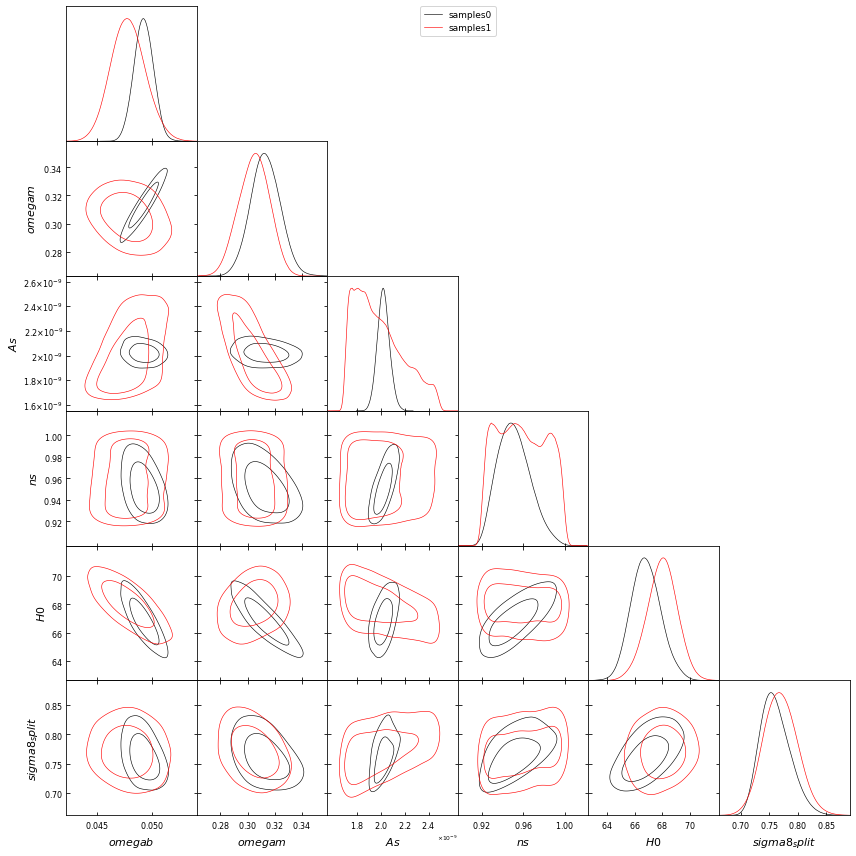

In [47]:
g = plots.get_subplot_plotter()
g.settings.num_plot_contours = 2
g.triangle_plot([chain1,chain2],
               filled=False,
               params=chains.params)

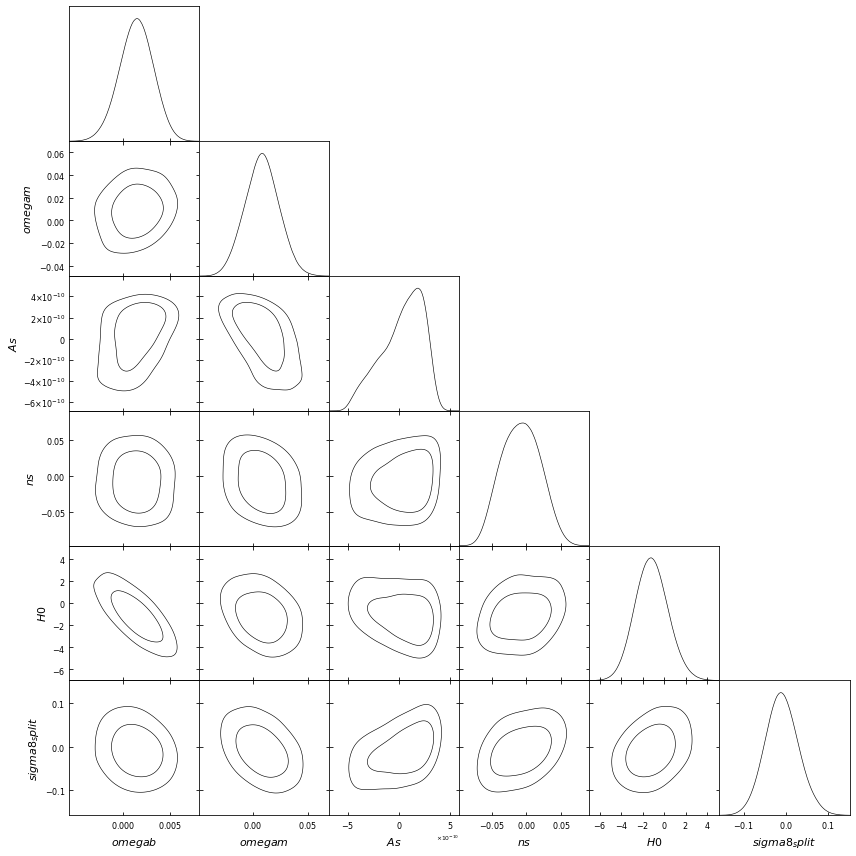

In [48]:
g = plots.get_subplot_plotter()
g.settings.num_plot_contours = 2
g.triangle_plot(chains.diff_chain,
               filled=False,
               params=chains.params)

In [49]:
maf = flow.MAF(len(chains.params))

---   MADE info   ---
 - Hidden_units = [12, 12]
 - Activation = <function asinh at 0x7fde28191320>

---   Model info   ---
 - N samples = 21244
 - Uniform weights = 1.0
 - Pre-Gaussian Map = True

 - Validation split = 0.1
 - Number MAFS = 12 
 - Trainable parameters = 4752 

[####################] Completed!                          


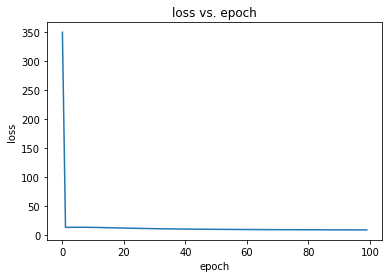

In [50]:
maf.setup()
maf.train(chains.diff_chain,batch_size=5000)

In [51]:
nsigma,high,low = tension.flow_significance(
                        maf.target_dist,
                        maf.gauss_bijector,
                        len(chains.params)
                        )
print(r"n_sigma = {:.5f} +{:.5f}/-{:.5f}".format(nsigma,high-nsigma,nsigma-low))

n_sigma = 0.05873 +0.00085/-0.00083


### Parameter Difference Update
We have one chain with data set *A* and another chain with two data sets *A+B*. Then the quantity

$$ Q_{UDM} = (\mu_A - \mu_{A+B})^T (C_A-C_{A+B})^{-1}(\mu_A - \mu_{A+B})$$

In practice $Q_{UDM}$ should be $\chi^2$ distributed with $\text{rank}(C_A-C_{A+B})$ degrees of freedom. This allows us to compute $n_\sigma$ using 

$$ \text{PTE} = \int\limits^{Q_{UDM}}_{0}\chi^2(x,d) dx $$

In [2]:
### Parameter difference in update form
# Import chains
lsst_path = '/home/grads/data/evan/mc_data/fiducial'
lsst_planck_path = '/home/grads/data/evan/LSST_emulation/joint_data'

# read with getdist
chains = diff.chain()
chain1 = chains.getdist_reader(lsst_path)
chain2 = chains.getdist_reader(lsst_planck_path)
chain2.setParamNames(['omegab', 'omegac', 'logA', 'ns', 'H0', 'h', 'tau', 'Aplanck'])
chains.chains = [chain1,chain2]
chains.diff()

/home/grads/data/evan/mc_data/fiducial.txt
Removed no burn in
/home/grads/data/evan/LSST_emulation/joint_data.txt
Removed no burn in

Params in first chain:
['logA', 'ns', 'H0', 'omegab', 'omegac']

Params in second chain:
['omegab', 'omegac', 'logA', 'ns', 'H0', 'h', 'tau', 'Aplanck']

 Common params found:
['logA', 'ns', 'H0', 'omegab', 'omegac']

N1 = 1128000
N2 = 240000


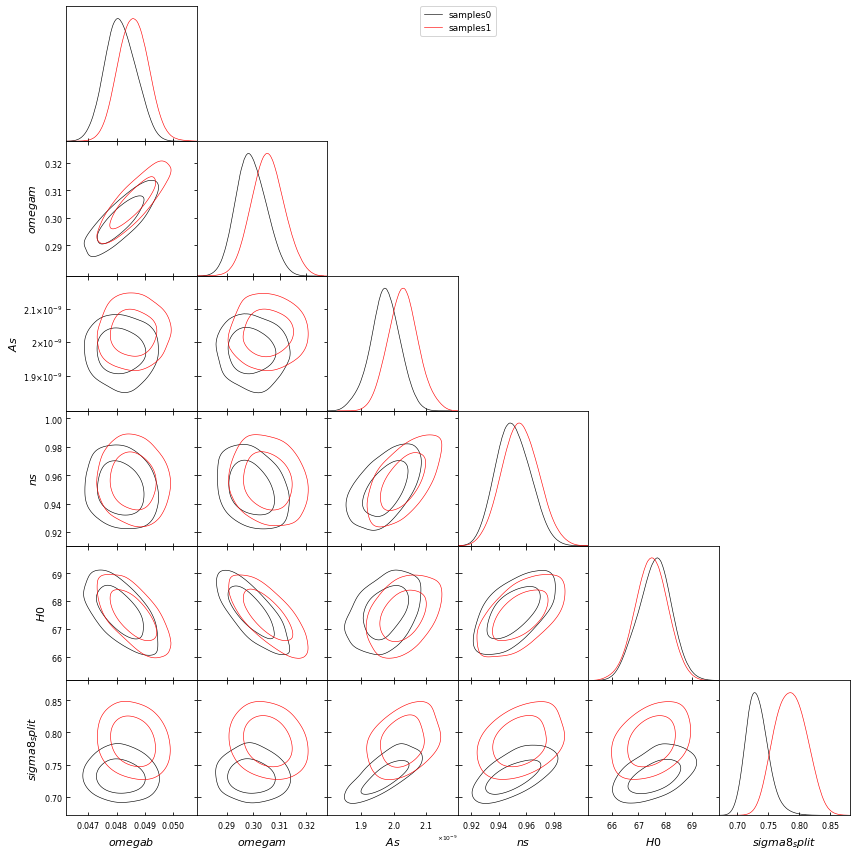

In [41]:
g = plots.get_subplot_plotter()
g.settings.num_plot_contours = 2
g.triangle_plot([chain1,chain2],
               filled=False,
               params=chains.params)

In [42]:
qudm_estimate = qudm(chain1,chain2,feedback=True)

dof = 5
Q_UDM = -4.75294e+00

n_sigma = 0.0


### Goodness of Fit Degradation
$$ Q_{\mathrm{DMAP}} = 2\mathcal{L}_A(\hat\theta_A) + 2\mathcal{L}_B(\hat\theta_B) - 2\mathcal{L}_{AB}(\hat\theta_{AB})$$
with $\hat\theta$ the Maximum a Posteriori, the point that maximizes the posterior. Getdist can sometimes store this information, but if it doesn't one can use scipy to optimize the posterior and the emulators to find the likelihood. $Q_{\mathrm{DMAP}}$ is $\chi^2$ distributed, so 
$$ \mathrm{PTE} = \int\limits_{0}^{Q_{\mathrm{DMAP}}}\chi^2(x,d)dx $$

In [4]:
# Import chains
planck_path = '/home/grads/data/evan/cosmopower_emcee/notebooks/planck_emulated'
lsst_path = '/home/grads/data/evan/mc_data/fiducial'
lsst_planck_path = '/home/grads/data/evan/LSST_emulation/joint_data'

chains = diff.chain()
chain1 = chains.getdist_reader(planck_path)
chain2 = chains.getdist_reader(lsst_path)
chain3 = chains.getdist_reader(lsst_planck_path)

print(chain1.getParamNames().getRunningNames())
print(chain2.getParamNames().getRunningNames())
print(chain3.getParamNames().getRunningNames())

chain3.setParamNames(['omegab', 'omegac', 'logA', 'ns', 'H0', 'h', 'tau', 'Aplanck'])

/home/grads/data/evan/cosmopower_emcee/notebooks/planck_emulated.txt
Removed no burn in
/home/grads/data/evan/mc_data/fiducial.txt
Removed no burn in
/home/grads/data/evan/LSST_emulation/joint_data.txt
Removed no burn in
['omegab', 'omegac', 'h', 'tau', 'ns', 'logA', 'Aplanck']
['logA', 'ns', 'H0', 'omegab', 'omegac']
['omegabh2', 'omegach2', 'logAs', 'ns', 'H0', 'tau', 'Aplanck', 'chi2']


#### Since these chains do not have MAP in them, we need the utility to find the max using tensorflow+scipy

In [5]:
lsst_emulator = lsst.lsst_emulator()
cosmopower_emulator = cosmopower.cosmopower()

2022-09-30 12:20:14.733873: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1932] Ignoring visible gpu device (device: 1, name: NVIDIA GeForce GT 730, pci bus id: 0000:c1:00.0, compute capability: 3.5) with core count: 2. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
2022-09-30 12:20:14.734182: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-30 12:20:15.197718: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3375 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 960, pci bus id: 0000:09:00.0, compute capability: 5.2
2022-09-30 12:20:15.579775: I tensorflow/core/uti

In [8]:
# step 1: setup the posterior as a callable function
#         and use the maximization utility
# minimize -logprob
def log_prob(theta):
    theta = np.reshape(theta.astype('float32'),(7))
    p = cosmopower_emulator.tf_planck.posterior(np.array([theta],np.float32)).numpy()[0]
    if( p == -1*np.inf ):
        p = -1e32
    return -1 * p

In [9]:
# step 3: use maximization utility
#initial = np.array([ 0.022242,  0.11977,  0.673,  0.055,  0.9658,  3.0753,  1.0080])
region = [0.2,1.0,0.5,0.5,1.0,2.0,0.1]
initial = chain1.getMeans()
upbound = initial + region
lobound = initial - region
bounds = [lobound,upbound]
results=[]

for i in range(20):
    map_a =  pybobyqa.solve(log_prob,
                        initial,
                        rhobeg=0.01,
                        rhoend=1e-12,
                        maxfun=500,
                        bounds=bounds,
                        seek_global_minimum=True
                       )
    results.append([map_a.x,map_a.f])

In [12]:
# step 3: calculate log lkl
print(results)
lkl_a = cosmopower_emulator.tf_planck.get_loglkl(np.array([map_a.x],dtype=np.float32)).numpy()[0]
print(lkl_a)

[[array([ 3.08920293e+00,  9.69661237e-01,  6.85879468e+01,  2.25175058e-02,
        1.18489164e-01,  4.06529013e-04, -4.52011909e-05, -2.79699787e-04,
       -4.41840235e-05, -3.14066808e-04,  5.00434416e-01,  3.34788409e-03,
        5.95437574e-04,  1.27664157e-03,  1.24166094e-03,  2.13106606e-04,
        1.78695648e-03,  1.23965064e+00,  1.35995795e+00,  1.46851198e+00,
        1.59776689e+00,  1.76064047e+00,  8.97100347e-04,  1.41251958e-03,
        6.70877254e-04, -2.18649387e-03, -3.46179931e-03,  1.18375417e-03,
       -8.60751368e-04,  8.49179244e-02,  9.93881893e-01]), 288.3134404703739], [array([ 3.09024048e+00,  9.70339210e-01,  6.85915864e+01,  2.25102705e-02,
        1.18440063e-01,  4.17330328e-04, -4.59141740e-04, -3.89846082e-05,
       -4.75116729e-04, -3.10461903e-06,  5.01087120e-01, -2.11414513e-03,
        3.89574459e-04,  2.30432743e-04,  3.87764369e-04,  3.51604421e-04,
        6.55627158e-04,  1.23540506e+00,  1.35963644e+00,  1.46853181e+00,
        1.5978499

In [137]:
# just do the same for the others
def log_prob(theta):
    #theta = np.array([theta])
    p = lsst_emulator.log_prob(theta)
    if( p == -1*np.inf ):
        p = -1e32
    return -1 * p

initial = chain2.getMeans()
initial = np.array([3.01273691e+00, 9.58661626e-01, 7.14349796e+01, 2.55546828e-02, 1.28688739e-01, 
          0., 0., 0., 0., 0.,
          0.5, 0.,
          0., 0., 0., 0., 0.,
          1.24, 1.36, 1.47, 1.60, 1.76,
          0., 0., 0., 0., 0.,
          0., 0.])

map_b = pybobyqa.solve(log_prob,initial)

lkl_b = lsst_emulator.log_lkl(map_b.x)
print(lkl_b)

-4.865998650708183


In [11]:
def log_prob(theta):
    planck_idxs = [3,4,2,29,1,0,30]
    theta_lsst = theta[:29]
    theta_planck = np.array(theta)[planck_idxs]
    theta_planck[2] = theta_planck[2]/100
    lsst_prob = lsst_emulator.log_prob(theta_lsst)
    planck_prob = cosmopower_emulator.tf_planck.posterior(np.array([theta_planck],dtype=np.float32)).numpy()[0]
    p = ( lsst_prob + planck_prob )
    if( p == -1*np.inf ):
        p = -1e32
    return -1*p

# [2.24870198e-02 1.19308785e-01 3.07939999e+00 9.68408363e-01
# 6.90987203e+01 6.82794349e-01 7.21778524e-02 1.00065000e+00]
initial_temp = chain3.getMeans()

initial = np.array([3.0675, 0.97, 69.0, 0.0228528, 0.1199772, 
                      0., 0., 0., 0., 0.,
                      0.5, 0.,
                      0., 0., 0., 0., 0.,
                      1.24, 1.36, 1.47, 1.60, 1.76,
                      0., 0., 0., 0., 0.,
                      0., 0.,0.1235,1.0007])
initial[0] = initial_temp[2]
initial[1] = initial_temp[3]
initial[2] = initial_temp[4]
initial[3] = initial_temp[0]
initial[4] = initial_temp[1]

region = [2,1,40,0.5,1,
             1,1,1,1,1,
             1,1,
             1,1,1,1,1,
             1.0,1.0,1.0,1.0,1.0,
             1,1,1,1,1,
             1,1,1,1]
upbound = initial + region
lobound = initial - region
bounds = [lobound,upbound]

results = []
for i in range(20):
    map_ab = pybobyqa.solve(log_prob,initial,rhobeg=0.01,rhoend=1e-12,
                      maxfun=500,
                      bounds=bounds,
                      seek_global_minimum=True)
    results.append([map_ab.x,map_ab.f])

planck_idxs = [3,4,2,29,1,0,30]
map_ab_lsst = map_ab.x[:29]
map_ab_planck =  map_ab.x[planck_idxs]
map_ab_planck[2] = map_ab_planck[2]/100
lkl_ab = lsst_emulator.log_lkl(map_ab_lsst)+cosmopower_emulator.tf_planck.get_loglkl(np.array([map_ab_planck],dtype=np.float32)).numpy()[0]
print(lkl_ab)

-295.8741005362437


In [141]:
# now we can use the qdmap function
priors = {'omegab':  [0.001, 0.04],
          'omegac':  [0.005, 0.99],
          'h':       [0.2,   1.0],
          'H0':      [55,    91],
          'tau':     [0.01,  0.8],
          'ns':      [0.9,   1.1],
          'logA':    [1.61,  3.91],
          'Aplanck': [1.0,   0.01],
         }

#qdmap = 2*( (lkl_a) + (lkl_b) - (lkl_ab) )
#print(qdmap)
# compute n_sigma
#pte = scipy.stats.chi2.cdf(qdmap, 6.96914)
#n_sigma = np.sqrt(2)*scipy.special.erfinv(pte)
#print(n_sigma)
print(lkl_a,lkl_b,lkl_ab)

n_sigma = q_dmap(chain1,chain2,chain3,prior_dict=priors,lkl_a=lkl_a,lkl_b=lkl_b,lkl_ab=lkl_ab)
print(n_sigma)

-288.7743 -4.865998650708183 -298.95740819043374
Using given likelihoods.
Q_DMAP = 10.63424
dof = 6.96914
1.4273157608578688


In [115]:
likea=0
for param in chain1.getLikeStats().list():
    likea += chain1.getLikeStats().parWithName(param).bestfit_sample

likeb=0
for param in chain2.getLikeStats().list():
    likeb += chain2.getLikeStats().parWithName(param).bestfit_sample

likeab=0
for param in chain3.getLikeStats().list():
    likeab += chain3.getLikeStats().parWithName(param).bestfit_sample
print(likea,likeb,likeab)
n_sigma = q_dmap(chain1,chain2,chain3,prior_dict=priors,lkl_a=likea,lkl_b=likeb,lkl_ab=likeab)
print('\nn_sigma = {}'.format(n_sigma))

6.1296740852000005 73.151775305 76.334847901
Using given likelihoods.
Q_DMAP = 5.89320
dof = 6.96914

n_sigma = 0.5995937873372131


### Eigentension

1. Find the eigenvalues and eigenvectors of the LSST covariance.
2. Find the ratio of the variance in the prior and the posterior. Consider this mode well measured if the ratio is greater than 10^2
3. Project planck onto the well measured eigenvectors.
4. Compute the parameter difference PTE

Note that here, the less constraining experiment needs to be the first chain which gets diagonalized.

In [4]:
planck_path = '/home/grads/data/evan/cosmopower_emcee/notebooks/planck_emulated'
lsst_path = '/home/grads/data/evan/mc_data/fiducial'
chains = diff.chain()
chain1 = chains.getdist_reader(planck_path)
chain2 = chains.getdist_reader(lsst_path)

/home/grads/data/evan/cosmopower_emcee/notebooks/planck_emulated.txt
Removed no burn in
/home/grads/data/evan/mc_data/fiducial.txt
Removed no burn in


In [ ]:
# if the chain does not include prior limits, you can pass them manually
priors = {'omegab':  [0.001, 0.04],
          'omegac':  [0.005, 0.99],
          'h':       [0.2,   1.0],
          'tau':     [0.01,  0.8],
          'ns':      [0.9,   1.1],
          'logA':    [1.61,  3.91],
          'Aplanck': [1.0,   0.01],
         }

nsigma,high,low = eigentension(chain2,chain1,priors)

3 is robust!
adding the [0] eigenvector to well-measured subspace
Removed no burn in
Removed no burn in

Params in first chain:
['e3', 'e0']

Params in second chain:
['e3', 'e0']

 Common params found:
['e3', 'e0']

N1 = 1128000
N2 = 60000
